In [114]:
%matplotlib inline
from io import StringIO
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd

color_sequence = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#ff9896',
                  '#9467bd', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2',
                  '#7f7f7f', '#bcbd22', '#17becf']

def get_dataframes(base_dir):
    def get_filtered(keywords, filename):
        ret = ''
        with open(filename) as f:
            for line in f:
                for keyword in keywords:
                    if keyword in line:
                        ret += line
                        break
        return ret

    # All packets
    c = get_filtered(["new updates"], os.path.join(base_dir, "training.log"))
    df_accepted = pd.read_csv(
        StringIO(c),
        names=["debug", "ts", "_1", "_2", "_3", "machine_id", "node_id",
               "node_count", "depth", "gamma", "patch_size", "count_new", "count_updates"])
    df_accepted["packet_type"] = "accept"

    c = get_filtered(["empty"], os.path.join(base_dir, "training.log"))
    df_empty = pd.read_csv(
        StringIO(c), names=["debug", "ts", "_1", "_2", "_3",
                            "machine_id", "node_id", "node_count", "depth", "gamma", "cons_fail",
                            "gamma_sq", "duration", "gamma_sq_rate"])
    df_empty["packet_type"] = "empty"

    df_packets = pd.concat([df_accepted, df_empty], sort=False) \
                   .sort_values(by="ts")  \
                   .reset_index(drop=True)
    df_packets["total_packets"] = np.arange(1, df_packets.shape[0] + 1)
    df_packets["total_empty_packets"] = np.cumsum(df_packets["packet_type"] == "empty")
    df_packets["total_accept_packets"] = np.cumsum(df_packets["packet_type"] == "accept")

    # Assignments
    c = get_filtered(["assign,"], os.path.join(base_dir, "training.log"))
    df_assign = pd.read_csv(
        StringIO(c), names=["debug", "ts", "_1", "_2", "_3",
                            "machine_id", "node_id", "is_found"])
    df_assign["is_found"] = (df_assign["is_found"] == " true") * 1

    # Broadcast new gamma
    c = get_filtered(["broadcast gamma,"], os.path.join(base_dir, "training.log"))
    df_bcast_gamma = pd.read_csv(
        StringIO(c), names=["debug", "ts", "_1", "_2", "_3",
                            "condition", "gamma", "root_gamma", "shrink_factor", "old_gamma"])

    # Generate new samples
    c = get_filtered(["finished, generate sample"], os.path.join(base_dir, "training.log"))
    df_sample = pd.read_csv(
        StringIO(c), names=["debug", "ts", "_1", "_2", "_3", "_4",
                            "num_scanned", "total_sample", "total_pos", "total_unique", "pos_unique",
                            "model_size"])

    # Model performance
    c = get_filtered([""], os.path.join(base_dir, "models/performance.csv"))
    df_perf = pd.read_csv(
        StringIO(c), names=["filename", "ts", "node_count", "loss", "AUPRC", "AUROC"],
    )

    return (df_packets, df_assign, df_bcast_gamma, df_sample, df_perf)


def plot_packets(ax, df_packets):
    df_packets.plot(
        x="ts", y="total_packets", ax=ax,
    )
    df_packets.plot(
        x="ts", y="total_accept_packets", ax=ax,
    )
    df_packets.plot(
        x="ts", y="total_empty_packets", ax=ax,
    )

    ax.set_title("Number of Packets Received by the Sampler")
    ax.grid();
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Number of Packets")
    ax.legend();


def plot_gamma(ax, df_bcast_gamma):
    df_bcast_gamma.plot(
        x="ts", y="gamma", ax=ax,
    )
    df_bcast_gamma.plot(
        x="ts", y="root_gamma", ax=ax,
    )

    ax.set_title("Values of Gamma over Training Time")
    ax.grid();
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Gamma")
    ax.legend();


def plot_perf(ax, df_perf):
    df_perf.plot(
        x="ts", y="loss", ax=ax[0],
    )
    df_perf.plot(
        x="ts", y="AUROC", ax=ax[1],
    )
    df_perf.plot(
        x="ts", y="AUPRC", ax=ax[2],
    )

    for axis, label in zip(ax, ["loss", "AUROC", "AUPRC"]):
        axis.set_title("{} on the Testing Dataset".format(label))
        axis.grid();
        axis.set_xlabel("Training Time")
        axis.set_ylabel(label)
        axis.legend();


def plot_strikes(ax, df_packets, df_sample):
    rows = df_packets[["ts", "packet_type"]].to_numpy().tolist()
    accept_strike = []
    empty_strike = []
    counter = 0
    for i in range(len(rows)):
        if i > 0 and rows[i][1] != rows[i - 1][1]:
            if rows[i - 1][1] == "empty":
                empty_strike.append((rows[i - 1][0], counter))
            else:
                accept_strike.append((rows[i - 1][0], counter))
            counter = 0
        counter += 1
    if rows[-1][1] == "empty":
        empty_strike.append((rows[-1][0], counter))
    else:
        accept_strike.append((rows[-1][0], counter))

    accept_strike = np.array(accept_strike)
    empty_strike = np.array(empty_strike)
    ax.scatter(accept_strike[:, 0], accept_strike[:, 1], label="Accept")
    ax.scatter(empty_strike[:, 0], empty_strike[:, 1], label="Empty")

    for ts in df_sample["ts"]:
        ax.axvline(x=ts, ls='--', alpha=0.5, color="gray");

    ax.grid()
    ax.legend();
    ax.set_xlabel("Timestamp");
    ax.set_ylabel("Length of the strikes")
    ax.set_title("Accept/Reject Strikes");


def plot_packet_node_indices(ax, df_packets):
    df_packets[df_packets["packet_type"] == "accept"].plot.scatter(
        x="ts", y="node_id", ax=ax[0],
    )
    df_packets[df_packets["packet_type"] == "empty"].plot.scatter(
        x="ts", y="node_id", ax=ax[1],
    )

    for axis, label in zip(ax, ["Accepted", "Empty"]):
        axis.set_title("Node indices of the {} nodes".format(label))
        axis.grid();
        axis.set_xlabel("Training Time")
        axis.set_ylabel("Node Indices");

/home/arapat/dev/virtualenv/py3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


count_new        632.0
count_updates    270.0
dtype: float64


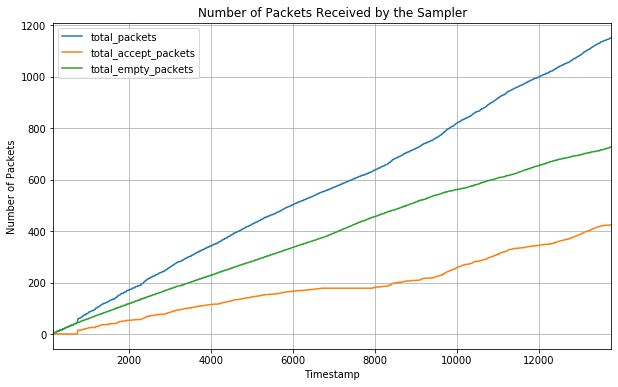

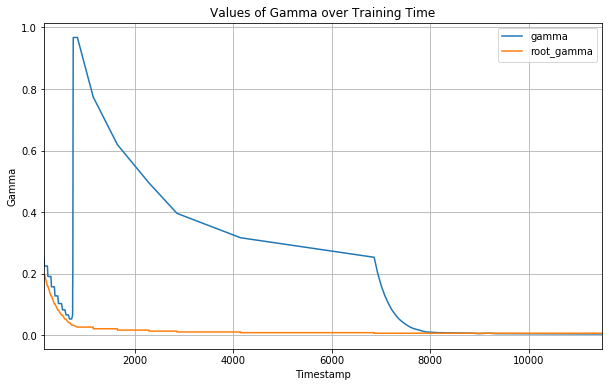

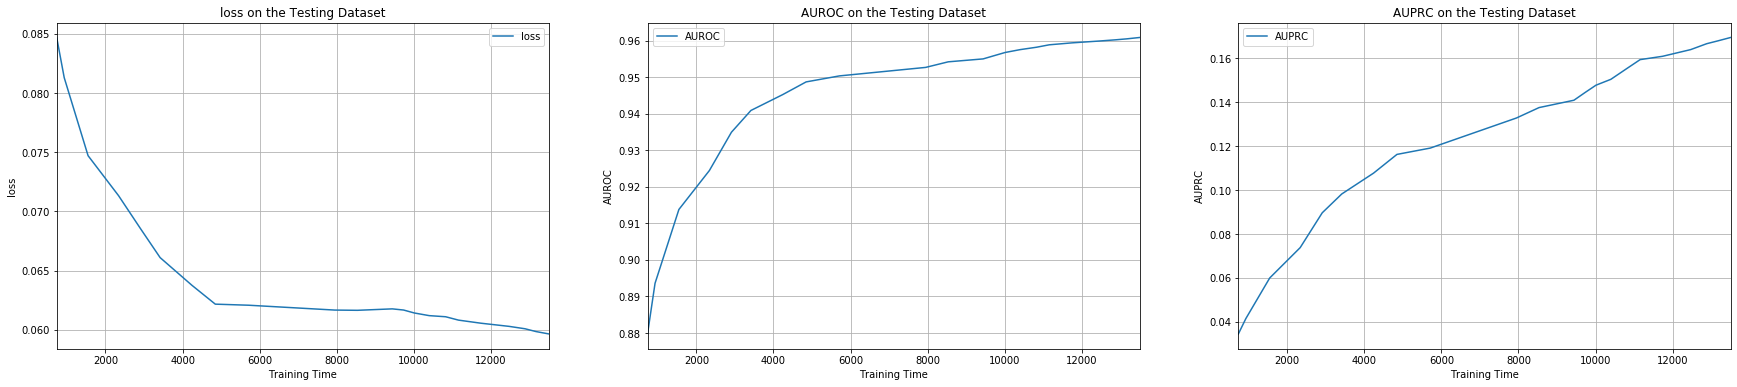

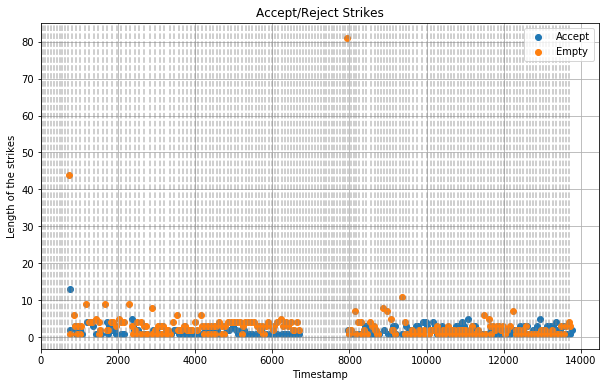

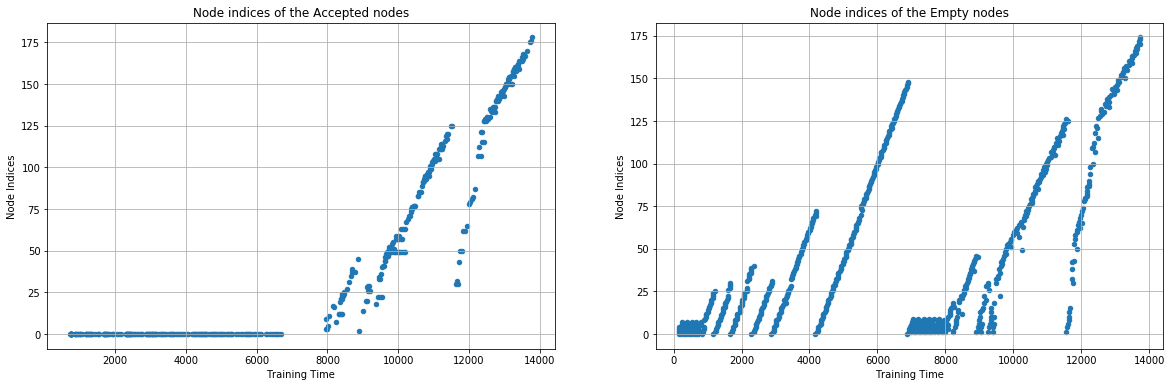

In [115]:
base_dir = "./dt-logs/cont-run"
(df_packets, df_assign, df_bcast_gamma, df_sample, df_perf) = get_dataframes(base_dir)
print(df_packets[["count_new", "count_updates"]].sum())

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_packets(ax, df_packets)


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_gamma(ax, df_bcast_gamma)


fig, ax = plt.subplots(1, 3, figsize=(30, 6))
plot_perf(ax, df_perf)


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_strikes(ax, df_packets, df_sample)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_packet_node_indices(ax, df_packets)